Training images: 2000
Testing images: 500


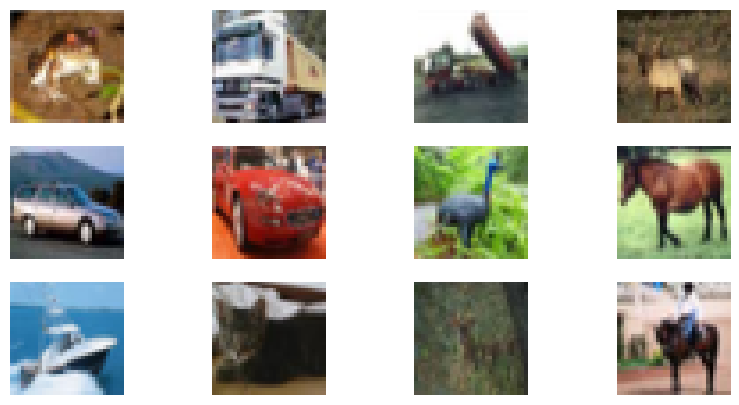

Training images before augmentation: 2000
Training images after augmentation (virtually): 2000
Testing images: 500
Epoch 1/15
63/63 [==============================] - 4s 36ms/step - loss: 2.1730 - accuracy: 0.1945 - val_loss: 2.1372 - val_accuracy: 0.2460
Epoch 2/15
63/63 [==============================] - 2s 27ms/step - loss: 1.8303 - accuracy: 0.3370 - val_loss: 1.7971 - val_accuracy: 0.3440
Epoch 3/15
63/63 [==============================] - 2s 28ms/step - loss: 1.6698 - accuracy: 0.4100 - val_loss: 1.7051 - val_accuracy: 0.3840
Epoch 4/15
63/63 [==============================] - 2s 28ms/step - loss: 1.5031 - accuracy: 0.4610 - val_loss: 1.6631 - val_accuracy: 0.3620
Epoch 5/15
63/63 [==============================] - 2s 28ms/step - loss: 1.3891 - accuracy: 0.5040 - val_loss: 1.5765 - val_accuracy: 0.4300
Epoch 6/15
63/63 [==============================] - 2s 28ms/step - loss: 1.2796 - accuracy: 0.5520 - val_loss: 1.5432 - val_accuracy: 0.4300
Epoch 7/15
63/63 [=====================

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# a) Load dataset (CIFAR-10 = ImageNet sample)
# -------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Use only sample images (training = 2000, testing = 500)
x_train, y_train = x_train[:2000], y_train[:2000]
x_test, y_test = x_test[:500], y_test[:500]

# -------------------------------
# b) Show number of training/testing images
# -------------------------------
print("Training images:", x_train.shape[0])
print("Testing images:", x_test.shape[0])

# -------------------------------
# c) Plot sample images
# -------------------------------
plt.figure(figsize=(10,5))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(x_train[i])
    plt.axis("off")
plt.show()

# -------------------------------
# d) Image Augmentation (contrast, flip, rotate)
# -------------------------------
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Augment the training set (duplicate for demonstration)
augmented_images = data_augmentation(x_train)

# -------------------------------
# e) After augmentation, show dataset size
# -------------------------------
print("Training images before augmentation:", x_train.shape[0])
print("Training images after augmentation (virtually):", augmented_images.shape[0])
print("Testing images:", x_test.shape[0])

# -------------------------------
# f) Normalize data
# -------------------------------
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

# -------------------------------
# g) Build CNN model
# -------------------------------
def build_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# -------------------------------
# h) Train CNN without augmentation
# -------------------------------
cnn_no_aug = build_cnn()
history_no_aug = cnn_no_aug.fit(
    x_train_norm, y_train,
    validation_data=(x_test_norm, y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)

# -------------------------------
# i) Build R-CNN-like network (Simple small region block)
# -------------------------------
def build_rcnn():
    inputs = tf.keras.Input(shape=(32,32,3))
    x = tf.keras.layers.Conv2D(32,3,activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)

    # Region-like extraction
    region = tf.keras.layers.Conv2D(64,3,activation='relu')(x)
    region = tf.keras.layers.GlobalAveragePooling2D()(region)

    x = tf.keras.layers.Dense(128, activation='relu')(region)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# -------------------------------
# j) Train R-CNN
# -------------------------------
rcnn_no_aug = build_rcnn()
history_rcnn_no_aug = rcnn_no_aug.fit(
    x_train_norm, y_train,
    validation_data=(x_test_norm, y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)

# -------------------------------
# Train with augmentation
# -------------------------------
cnn_aug = build_cnn()
history_aug = cnn_aug.fit(
    data_augmentation(x_train_norm), y_train,
    validation_data=(x_test_norm, y_test),
    epochs=15
)

# -------------------------------
# Compare Accuracy
# -------------------------------
print("\n=== Accuracy Before Augmentation (CNN) ===")
print("Train Accuracy:", history_no_aug.history['accuracy'][-1])
print("Test Accuracy:", history_no_aug.history['val_accuracy'][-1])

print("\n=== Accuracy After Augmentation (CNN) ===")
print("Train Accuracy:", history_aug.history['accuracy'][-1])
print("Test Accuracy:", history_aug.history['val_accuracy'][-1])

print("\n=== Accuracy Using R-CNN (No Augmentation) ===")
print("Train Accuracy:", history_rcnn_no_aug.history['accuracy'][-1])
print("Test Accuracy:", history_rcnn_no_aug.history['val_accuracy'][-1])